# Importing and file opening

In [1]:
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot
import hist
import mplhep
import vector
vector.register_awkward()

fname = "/nfs/dust/cms/user/matsch/for_Artak/0520A050-AF68-EF43-AA5B-5AA77C74ED73.root"

fname_HH = "/nfs/dust/cms/user/frahmmat/tutorial_files/HHtobbVV_4B83EAAD-1DEF-1641-BF6E-E9D72832F33A.root"
fname_tt = "/nfs/dust/cms/user/frahmmat/tutorial_files/tt_sl_0520A050-AF68-EF43-AA5B-5AA77C74ED73.root"

# when opening a file using uproot different types of data are written in a dictionary
file = uproot.open(fname)

# particular data categories can be accessed using the known "key" "value" method using sqare brackets
tree = file["Events"]
print(tree)
# print(tree.keys())  # 1628 keys

<TTree 'Events' (1628 branches) at 0x7ff1b66ce320>


# Directly accessing fields via filter

In [2]:
tree = file["Events"]

fields = ["pt", "eta", "phi", "mass", "charge", "btagDeepB"]

# with arrays branches are selected by name
# here different branches are selected for various particles/jets
# the first 100_000 entries are to be used
electrons = tree.arrays(filter_name=["Electron_" + f for f in fields], entry_stop=100_000)
muons = tree.arrays(filter_name=["Muon_" + f for f in fields], entry_stop=100_000)
jets = tree.arrays(filter_name=["Jet_" + f for f in fields], entry_stop=100_000)

# print(electrons[48])

In [3]:
# switch naming of fields from "{Object}_{field}" to "{field}"

# the replace is used to rename the data subcategories regarding the electrons, muons and jets
# the goal is to combine all "particle arrays" to a a single "events array"
# wher in the subcategories the attributes are no more referenced as particle_attribute but simply as the attributes
electrons = ak.zip({key.replace("Electron_",""):electrons[key] for key in electrons.fields}, with_name="Momentum4D")
muons = ak.zip({key.replace("Muon_",""):muons[key] for key in muons.fields}, with_name="Momentum4D")
jets = ak.zip({key.replace("Jet_",""):jets[key] for key in jets.fields}, with_name="Momentum4D")

# combine fields into a single awkward "events array" via ak.zip
events = ak.zip({"Electron": electrons, "Muon": muons, "Jet": jets}, depth_limit=1)

# save output as parquet file
f_out_name = "tt_sl_test.parquet"
ak.to_parquet(events, f_out_name)

# the different subcategories can still be accessed by using the particle type and physical quantities as attributes
# Depending on the number of particles of a certain type measured in a single event
# the lists corresponding to the arrays contain multiple numbers

print("Electron fields: ", events.Electron.fields)
print("Muon fields:     ", events.Muon.fields)
print("Jet fields:      ", events.Jet.fields)

print("")

print("Electron pt for events 104-108: ", events.Electron.pt[104:108])
print("Muon pt for events 104-108:     ", events.Muon.pt[104:108])
print("Jet pt for events 104-108:      ", events.Jet.pt[104:108])

Electron fields:  ['eta', 'mass', 'phi', 'pt', 'charge']
Muon fields:      ['eta', 'mass', 'phi', 'pt', 'charge']
Jet fields:       ['btagDeepB', 'eta', 'mass', 'phi', 'pt']

Electron pt for events 104-108:  [[32.9, 25.9, 5.25], [150, 69], [35.8, 12.9], [13.6]]
Muon pt for events 104-108:      [[3.72], [8.69], [4.65], [54.5]]
Jet pt for events 104-108:       [[76.3, 64.9, 48.9, 41.4, 27, 18.5, 17.6], ... 37.8, 17.3], [63.2, 54.2, 36.7, 16.1]]


# Opening parquet with awkward

In [4]:
events_new = ak.from_parquet("tt_sl_test.parquet")

print(events_new.fields)

# is Electron here the keyword from above i.e. is the attribute always given by the keyword?
print(type(events_new.Electron))
# enable 4-vector behavior (pt,eta,phi,mass)
behaviors = {
    "Jet": "Momentum4D",
    "Electron": "Momentum4D",
    "Muon": "Momentum4D",
}

# attributes are being renamed such that the objects can be seen as 4 vectors with characteristic 4 vector calculations
for f in events_new.fields:
    if f in behaviors:
        events_new[f] = ak.with_name(events_new[f], behaviors[f])
    
print(events_new.fields)
print(type(events_new.Electron))

['Electron', 'Muon', 'Jet']
<class 'awkward.highlevel.Array'>
['Electron', 'Muon', 'Jet']
<class 'vector._backends.awkward_.MomentumArray4D'>


In [5]:
# playing around with fields, testing vector behaviour
jets = events_new.Jet

print("Number of jets:         ", ak.num(jets))
print("Jet mass:               ", jets.mass)

print("")
# select events with more jets than one
jets = jets[ak.num(jets)>1]
print("Mass of first two jets: ", (jets[:,0]+jets[:,1]).mass)
print("Jet pt:                 ", jets.pt)
print("pt of first two jets:   ", (jets[:,0]+jets[:,1]).pt)
print("Jet energy:             ", jets.E)
print("Jet energy (custom):    ", np.sqrt(jets.pt**2 + jets.pz**2 + jets.mass**2))


Number of jets:          [6, 7, 7, 9, 7, 8, 6, 5, 6, 8, 6, 10, 9, ... 6, 11, 7, 7, 8, 11, 8, 5, 9, 16, 11, 8]
Jet mass:                [[11.3, 9.84, 7.24, 4.14, 4.92, 3.79], ... 8.74, 5.56, 5.16, 6.71, 4.8, 6.57, 4.31]]

Mass of first two jets:  [86.9, 303, 203, 542, 108, 246, 105, 309, ... 271, 149, 184, 412, 59.7, 327, 147]
Jet pt:                  [[101, 62.8, 47.9, 22.3, 19.2, 15.5], ... 42.2, 40.2, 35.8, 33.5, 27, 21.2, 15.1]]
pt of first two jets:    [157, 56.7, 146, 84.8, 108, 83.2, 35.4, ... 78.4, 76, 37.1, 67.9, 194, 23.3, 38.2]
Jet energy:              [[118, 66.1, 49.1, 274, 49.1, 30.9], ... 43.2, 79.3, 48.1, 35.8, 182, 156, 105]]
Jet energy (custom):     [[118, 66.1, 49.1, 274, 49.1, 30.9], ... 43.2, 79.3, 48.1, 35.8, 182, 156, 105]]


# Masking events

In [6]:
# dummy mask

a = np.array([1, 2, 3, 4, 5])

mask = (a > 2) & (a != 4)

# use mask on array
print(a[mask])

[3 5]


In [7]:
# define a pt mask for electrons

electrons = events_new.Electron

selection = electrons.pt[104:108]

mask_e_pt = (selection > 15)
mask_e_pt_num = (ak.num(selection) < 3) & (selection > 15)

print("Electron events w/o masking:           ", selection)
print("Electron events w/ pt masking:         ", selection[mask_e_pt])
print("Electron events w/ pt and num masking: ", selection[mask_e_pt_num])

Electron events w/o masking:            [[32.9, 25.9, 5.25], [150, 69], [35.8, 12.9], [13.6]]
Electron events w/ pt masking:          [[32.9, 25.9], [150, 69], [35.8], []]
Electron events w/ pt and num masking:  [[], [150, 69], [35.8], []]


In [8]:
muons = events_new.Muon

muons.fields

print(np.sum(ak.num(muons)))

mask_m = (ak.num(muons) == 2) & (np.abs(muons.eta) < 0.0001)

print(np.sum(ak.num(muons[mask_m])))

96975
1


In [9]:
# jet pt > 30 GeV
# jet |eta| < 2.4
# lepton id

# Number of events vs number of jets

We shall now conduct an "analysis" on jets. Specifically, we want to examine the distribution of events in dependance of the number of jets satisfying particular requirements. Namely $p_T > 30 \,\, \text{GeV}$ and $|\eta| < 2.4$.

For this we need to make various cuts on our data. The cuts are performed in a particular order: object cuts first, event cuts second.

In [85]:
# jet data
jets = events_new.Jet

In [91]:
# create a mask that cuts objects
def object_mask(obj, eta, pt):
    
    return (np.abs(obj.eta) < eta) & (obj.pt > pt)

# create mask that cuts events by requiring a certain number of objects
def event_mask(event, n):
     
    return (ak.num(event) == n)


# masking function
def mask_events(event_data, obj_type, cut_eta, cut_pt, cut_n):
    
    """
    mask_events performs cuts on eta, pt and the 
    number of one specified object type on the full event data.
    
    event_data (awkward array): full event data
    obj_type (string): 'Electron', 'Muon', 'Jet'
    cut_eta (float): cut at specified eta
    cut_pt (float): cut at specified pt
    cut_n (int): cut events with specified number of objects
    """
    
    # mask for object based cuts on the full event data
    mask_obj = object_mask(event_data[obj_type], cut_eta, cut_pt)
    
    # apply object based cuts on full event data
    event_data[obj_type] = event_data[obj_type][mask_obj]
    events_masked_obj = event_data
            
    # event based cut
    mask_n = event_mask(event_data[obj_type], cut_n)

    # apply event based cut on object-masked data
    events_masked_final = events_masked_obj[mask_n]

    # number of events after performing cuts
    events_n_final = ak.num(events_masked_final)

    return events_masked_final, events_n_final, len(events_n_final)
    

In [93]:
result = mask_events(events, 'Jet', 2.4, 30, 2)

for i in range(len(result)):
    print(result[i])

[{Electron: [{eta: 1.14, mass: 0.00644, phi: -0.00438, ... phi: 0.828, pt: 48.7}]}]
[{Electron: 1, Muon: 0, Jet: 2}, {Electron: 0, ... {Electron: 2, Muon: 0, Jet: 2}]
9626


# BACKUP CELLS

In [12]:
#### for loop for various jet number counts

# object cuts first
# jet |eta| < 2.4 & jet pt > 30 GeV
jets_masked_obj = mask_pt(mask_eta(jets, 2.4), 30)

jets_masked_ev = [None for i in range(1, 7)]

for i in range(1, 7):
    jets_masked_ev[i-1] = mask_num(jets_masked_obj, i)

jets_num_events = [None for i in range(1, 7)]    
    
# get the number of events from final mask
for i, jet in enumerate(jets_masked_ev):    
    jets_num_events[i] = len(ak.num(jet))
    
print(jets_num_events)

[2372, 9626, 22707, 29727, 21077, 9437]


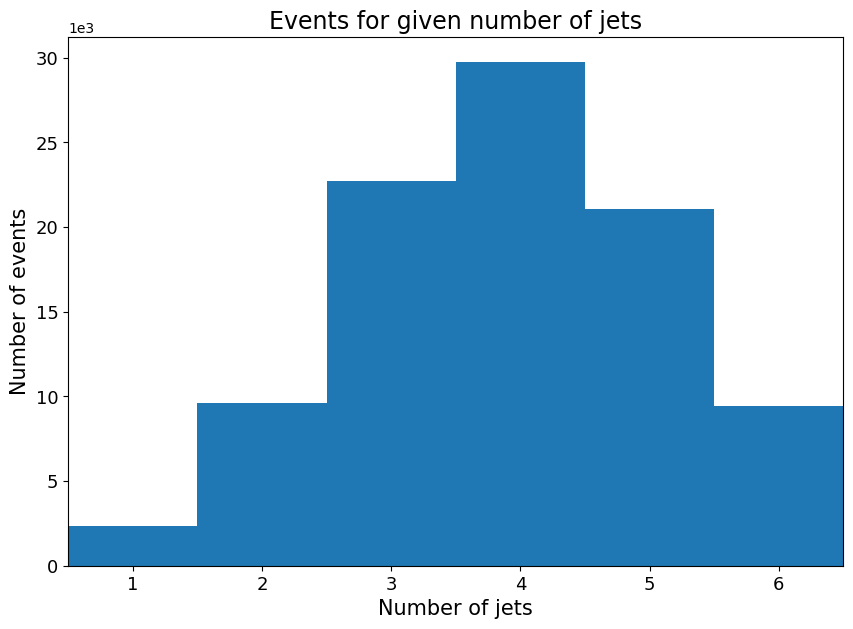

In [13]:
plt.figure(figsize = (10, 7), facecolor = 'white', dpi = 100)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (3, 3))

plt.bar(range(1, 7), jets_num_events, width = 1)

plt.title("Events for given number of jets", fontsize = 17)
plt.xlabel("Number of jets", fontsize = 15)
plt.ylabel("Number of events", fontsize = 15)

plt.xlim(0.5, 6.5)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.show()

In [86]:
# masks

# mask for cut on eta
def mask_eta(data, cut):
    
    mask = (np.abs(data.eta) < cut)
    
    return data[mask]

# mask for cut on pt
def mask_pt(data, cut):
    
    mask = (data.pt > cut)
    
    return data[mask]

# cut on number of events
def mask_num(data, cut):
    
    mask = (ak.num(data) == cut)
    
    return data[mask]


number_of_jets = ak.num(jets_2)
print(number_of_jets)

jets_masked_obj = mask_pt(mask_eta(jets_2, 2.4), 30)
number_of_jets_masked = ak.num(jets_masked_obj)
print(number_of_jets_masked)

jets_masked_num = mask_num(jets_masked_obj, 1)
number_of_jets_masked_2 = ak.num(jets_masked_num)
print(number_of_jets_masked_2)
print(len(number_of_jets_masked_2))



counter = 0

for i in number_of_jets_masked:
    
    if i == 1:
        
        counter += 1
        
print(counter)

[6, 7, 7, 9, 7, 8, 6, 5, 6, 8, 6, 10, 9, ... 6, 11, 7, 7, 8, 11, 8, 5, 9, 16, 11, 8]
[3, 4, 3, 6, 2, 4, 2, 4, 3, 3, 5, 6, 4, 5, ... 6, 2, 4, 5, 4, 5, 3, 4, 2, 6, 5, 5, 5]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2372
2372


In [87]:
# masking function
def mask_events(event_data, obj_type, cut_eta, cut_pt, cut_n = None, hist_bins = (0, 0)):
    
    """
    mask_events performs cuts on eta, pt and the 
    number of the specified objects on the full event data.
    
    event_data (awkward array): full event data
    obj_type (string): 'Electron', 'Muon', 'Jet'
    cut_eta (float): cut at specified eta
    cut_pt (float): cut at specified pt
    cut_n (int): cut events with specified number of objects
    hist_bins ((int, int)): 
    
    Either specify cut_num or hist_bins, don't 
    specify both and don't specify neither!
    """
    
    # mask for object based cuts on the full event data
    mask_obj = (np.abs(event_data[obj_type].eta) < cut_eta) & (event_data[obj_type].pt > cut_pt)
    
    # apply object based cuts on full event data
    event_data[obj_type] = event_data[obj_type][mask_obj]
    events_masked_obj = event_data
    
    if cut_n != None:
        
        # event based cut
        mask_n = (ak.num(event_data[obj_type]) == cut_n)
        
        # apply event based cut on object-masked data
        events_masked_final = events_masked_obj[mask_n]
        
        # number of events after performing cuts
        events_n_final = ak.num(events_masked_final)
        
        return events_masked_final, events_n_final, len(events_n_final)
    
    else:
        
        # bins to be used in the histogram
        bins = range(hist_bins[0], hist_bins[1] + 1)
        
        # storage list for the number of events
        events_n_bins = [None for _ in bins]
        
        for i, b in enumerate(bins):
            
            # event based cut per bin
            mask_n_b = (ak.num(event_data[obj_type]) == b)
            
            # apply event based cut on object-masked data per bin
            events_masked_final_b = events_masked_obj[mask_n_b]

            # number of events after performing cuts
            events_n_bins[i] = len(ak.num(events_masked_final_b))
            
        return events_n_bins
    